In [1]:
import pandas
import numpy

import os.path


In [2]:
dataset_path = './data/cnc-mill-toolwear'

In [3]:

def load_experiments(dataset_path):

    metadata_path = os.path.join(dataset_path, 'train.csv')
    df = pandas.read_csv(metadata_path)

    df = df.drop(columns='material') # only "wax", not so useful
    df = df.rename(columns={'No': 'experiment'})
    df = df.set_index('experiment')
    categorical_columns = ['tool_condition', 'machining_finalized', 'passed_visual_inspection']
    for c in categorical_columns:
        df[c] = df[c].astype('category')

    return df

                                 
experiments = load_experiments(dataset_path)
experiments

,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
experiment,,,,,
1,6,4.0,unworn,yes,yes
2,20,4.0,unworn,yes,yes
3,6,3.0,unworn,yes,yes
4,6,2.5,unworn,no,NaN
5,20,3.0,unworn,no,NaN
6,6,4.0,worn,yes,no
7,20,4.0,worn,no,NaN
8,20,4.0,worn,yes,no
9,15,4.0,worn,yes,no


In [4]:

def remove_bad_data(data):
    """
    From the dataset README.txt -- 
    Note: Some variables will not accurately reflect the operation of the CNC machine.
    This can usually be detected by
    when M1_CURRENT_FEEDRATE reads 50,
    when X1 ActualPosition reads 198,
    or when M1_CURRENT_PROGRAM_NUMBER does not read 0.
    The source of these errors has not been identified.
    """
    pass

def load_timeseries(dataset_path):

    dfs = []
    for ex in range(1, 18+1):
        path = os.path.join(dataset_path, f'experiment_{ex:02d}.csv')
        df = pandas.read_csv(path)
        df['experiment'] = ex
        df['time'] = pandas.to_timedelta(0.1 * numpy.arange(len(df)), unit='s') # 100ms / 10hz samplerate
        dfs.append(df)

    out = pandas.concat(dfs)
    out = out.set_index(['experiment', 'time'])
    return out

data = load_timeseries(dataset_path)
data


X1_ActualPosition  X1_ActualVelocity  \
experiment time                                                           
1          0 days 00:00:00                     198.0               0.00   
           0 days 00:00:00.100000              198.0             -10.80   
           0 days 00:00:00.200000              196.0             -17.80   
           0 days 00:00:00.300000              194.0             -18.00   
           0 days 00:00:00.400000              193.0             -17.90   
...                                              ...                ...   
18         0 days 00:03:44.800000              144.0              -2.30   
           0 days 00:03:44.900000              144.0              -2.47   
           0 days 00:03:45                     143.0              -2.20   
           0 days 00:03:45.100000              143.0              -2.05   
           0 days 00:03:45.200000              143.0              -2.15   

                                   X1_ActualAcceleration  X1_CommandPosition  \
experiment time                                                                
1          0 days 00:00:00                          0.00               198.0   
           0 days 00:00:00.100000                -350.00               198.0   
           0 days 00:00:00.200000                  -6.25               196.0   
           0 days 00:00:00.300000                   0.00               194.0   
           0 days 00:00:00.400000                 -18.80               192.0   
...                                                  ...                 ...   
18         0 days 00:03:44.800000                 100.00               144.0   
           0 days 00:03:44.900000                  25.00               144.0   
           0 days 00:03:45                         81.20               143.0   
           0 days 00:03:45.100000                  68.70               143.0   
           0 days 00:03:45.200000                 -68.70               143.0   

                                   X1_CommandVelocity  X1_CommandAcceleration  \
experiment time                                                                 
1          0 days 00:00:00                       0.00                0.000000   
           0 days 00:00:00.100000              -13.60             -358.000000   
           0 days 00:00:00.200000              -17.90               -0.000095   
           0 days 00:00:00.300000              -17.90               -0.000095   
           0 days 00:00:00.400000              -17.90                0.000095   
...                                               ...                     ...   
18         0 days 00:03:44.800000               -2.57                0.977000   
           0 days 00:03:44.900000               -2.46                1.080000   
           0 days 00:03:45                      -2.35                1.170000   
           0 days 00:03:45.100000               -2.23                1.260000   
           0 days 00:03:45.200000               -2.09                1.350000   

                                   X1_CurrentFeedback  X1_DCBusVoltage  \
experiment time                                                          
1          0 days 00:00:00                       0.18           0.0207   
           0 days 00:00:00.100000              -10.90           0.1860   
           0 days 00:00:00.200000               -8.59           0.1400   
           0 days 00:00:00.300000               -6.11           0.1300   
           0 days 00:00:00.400000               -5.70           0.1140   
...                                               ...              ...   
18         0 days 00:03:44.800000               -5.05           0.0732   
           0 days 00:03:44.900000               -5.62           0.0996   
           0 days 00:03:45                      -4.42           0.0539   
           0 days 00:03:45.100000               -5.83           0.0809   
           0 days 00:03:45.200000               -4.37           0.0857   

 

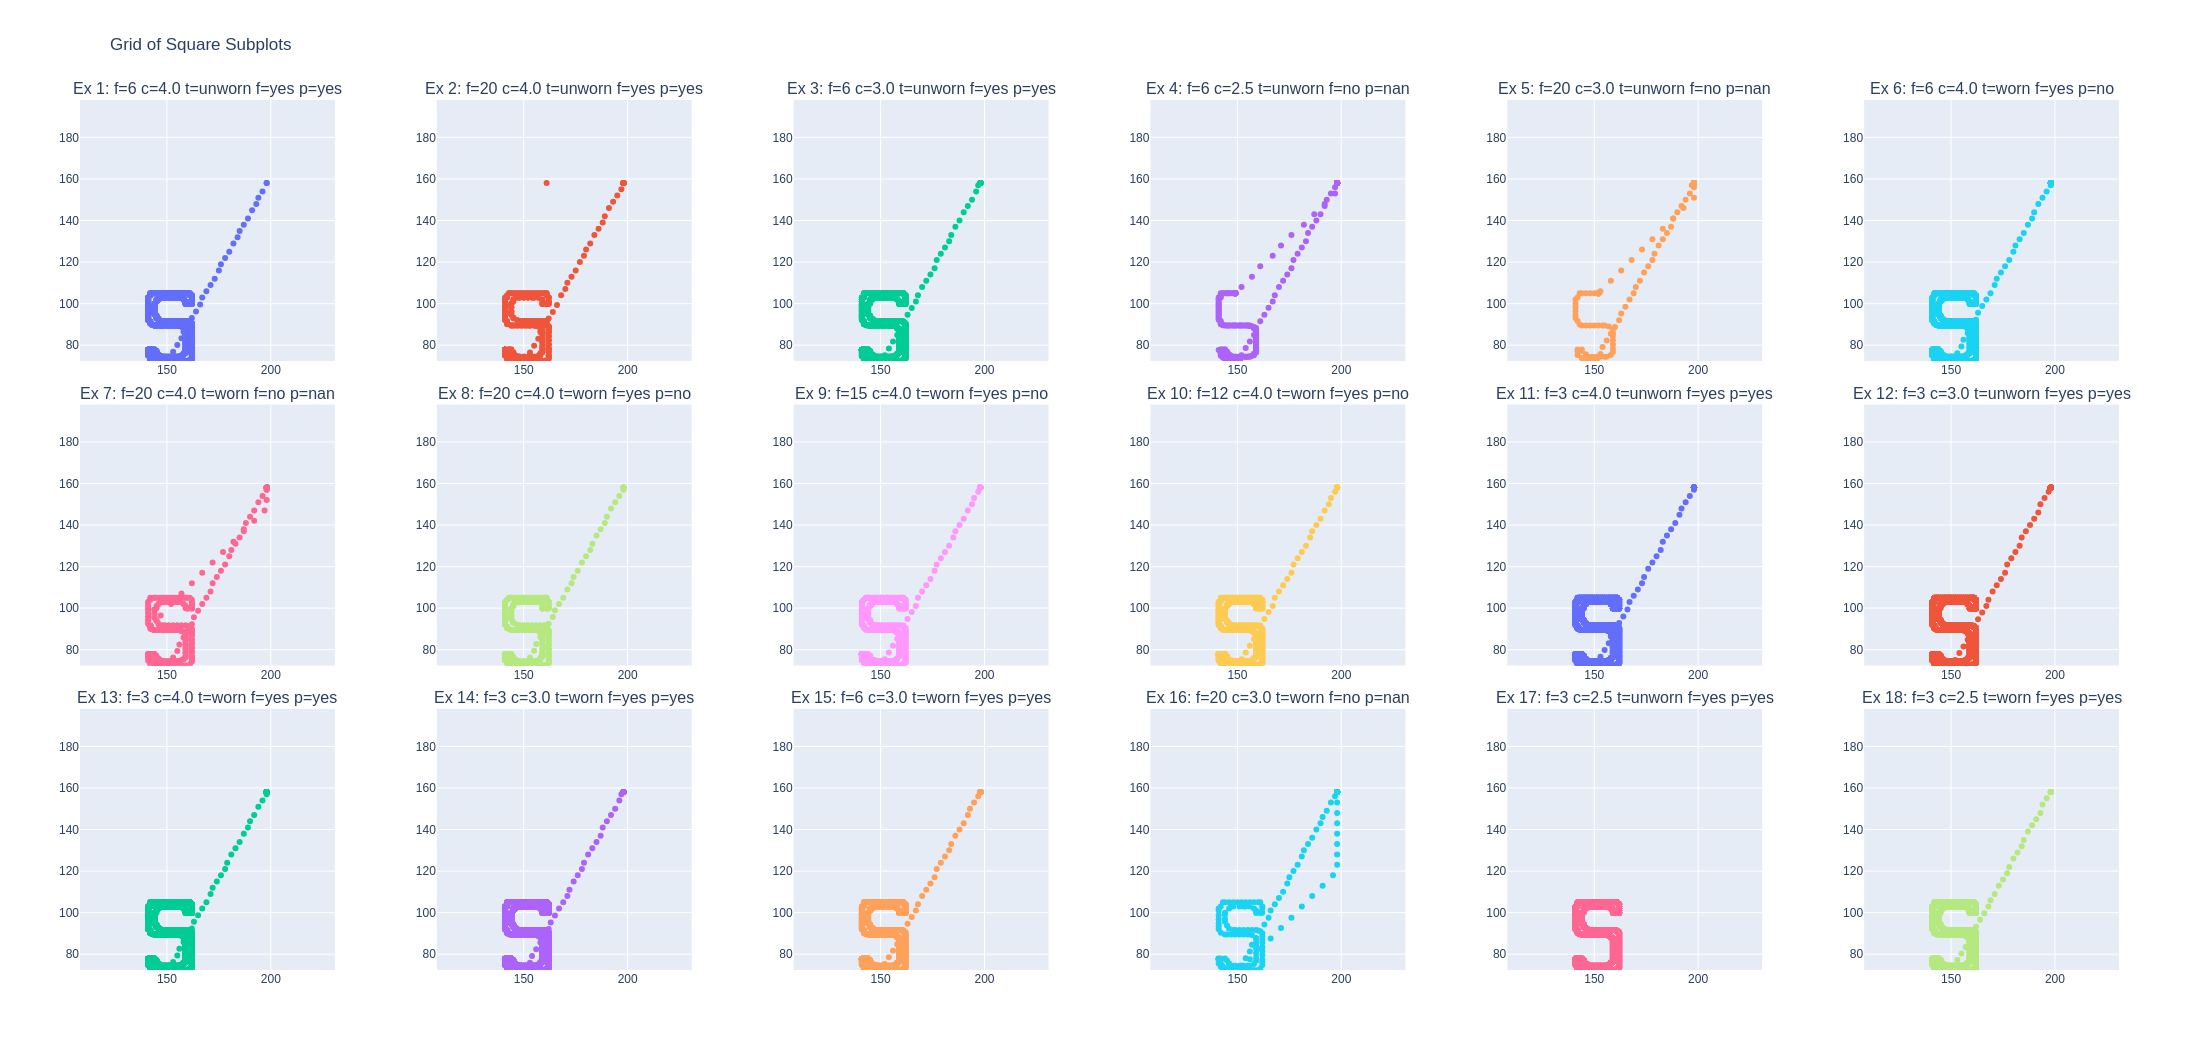

In [19]:

import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_square_subplot_grid(traces, x_range, y_range, cols=5, subplot_titles=None):
    """
    Create a grid of subplots with fixed number of columns (default=5),
    and each subplot has square X:Y axis (1:1 scale).
    
    Parameters:
    - traces: List of Plotly traces (one per subplot)
    - cols: Number of columns in the grid (default 5)
    - subplot_titles: Optional list of subplot titles
    
    Returns:
    - Plotly figure with square subplots
    """
    num_traces = len(traces)
    rows = math.ceil(num_traces / cols)

    fig = make_subplots(
        rows=rows,
        cols=cols,
        shared_xaxes=False,
        shared_yaxes=False,
        subplot_titles=subplot_titles if subplot_titles else ["" for _ in range(num_traces)],
        horizontal_spacing=0.05,  # More horizontal space between subplots
        vertical_spacing=0.05,     # Optional: space for subtitle/axis labels
    )

    for idx, trace in enumerate(traces):
        row = idx // cols + 1
        col = idx % cols + 1
        fig.add_trace(trace, row=row, col=col)
        axis_id = "" if idx == 0 else str(idx + 1)

        # Apply fixed range and square aspect
        fig.update_layout({
            f"xaxis{axis_id}": dict(range=x_range),
            f"yaxis{axis_id}": dict(range=y_range, scaleanchor=f"x{axis_id}", scaleratio=1),
        })

    fig.update_layout(
        height=350 * rows,
        width=350 * cols,
        showlegend=False,
        title_text="Grid of Square Subplots"
    )

    return fig
    

import plotly.express

def plot_positions(data):

    x_column = 'X1_ActualPosition'
    y_column = 'Y1_ActualPosition'
    
    x_range = data[x_column].min(), data[x_column].max(), 
    y_range = data[y_column].min(), data[x_column].max(), 
    
    traces = []
    titles = []
    for experiment, d in data.groupby('experiment'):    
        trace = go.Scatter(x=d[x_column], y=d[y_column], mode='markers')
    
        ex = experiments.loc[experiment]
        #print(ex)    
        traces.append(trace)
        describe = f"Ex {experiment}: f={ex['feedrate']} c={ex['clamp_pressure']} t={ex['tool_condition']} f={ex['machining_finalized']} p={ex['passed_visual_inspection']}"
        titles.append(describe)

    fig = create_square_subplot_grid(traces, x_range, y_range, cols=6, subplot_titles=titles)
    return fig

fig = plot_positions(data)
fig.show()


In [ ]:
data.columns

In [ ]:
data.Machining_Process.value_counts(dropna=False)

In [ ]:
data.M1_CURRENT_FEEDRATE.value_counts(dropna=False)

In [ ]:
data.M1_CURRENT_PROGRAM_NUMBER.value_counts(dropna=False)

In [ ]:
# TODO: plot time-series

# TODO: plot each run in X-Y
# maybe support overlay a variable, like spindle power?